Here I will go through the steps of determining the temperature of a gas of trapped atoms from spectroscopic data. As an example I will use lithium. I will use the packages that one typically uses to do this kind of analysis (Numpy, Scipy, Matplotlib).

We are analyzing a cloud of neutral Lithium 7 atoms in a trap. The cloud has some finite temperature. To probe the atoms we are scanning our laser over a transition, the 2S1/2 to 2p3/2 transition. The laser is illuminating the cloud of atoms which is much smaller than the diameter of the laser beam so each atoms sees the same power more or less. As we scan the laser at first no atoms are flourescing because we are very far from resonance. As we scan closer eventually atoms begin to flouresce and finally we hit a peak and head back down to zero (never actually zero)


The profile of this flourescence, like all (most?) hydrogen-like atomic transitions, is Lorentzian. There are several ways to show why this is. One is to model the electron as a spring attached to the nucleus, the result is a lorentzian response. Another way is to start with a lifetime, and from the uncertainty principle show that the frequency response is some finite width (cannot know the frequency and lifetime 100%). Since the atoms also have a temperature their velocity follows a gaussian distribution. This causes some atoms to be moving towards and some away from the laser, thus doppler shifting towards or away from resonance depending on the laser frequency.

The combination of these two effects is the convolution of a gaussian and a lorentzian, which gives a voigt. For given spectroscopic data, to extract the temperature one must fit the data with a voigt and then use the optimal values to determine the temperature. That is what we will do here.

In [1]:
import scipy.optimize as spo
import scipy.special as sps 
import numpy as np 
import matplotlib.pyplot as plt
from astropy.io import fits

We need to import the saved data and make it into the right format. The imported data is a series of 100 250x250 images. Each value in the array (matrix) of 250x250 is a pixel value. The goal is to sum up all those pixels for each image and make a new array of length 100 where each entry is the sum

(100, 250, 250)


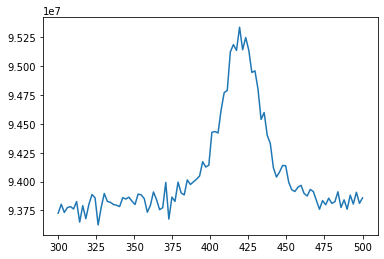

In [2]:
#The data is in the format of a series of images saved in a FITs file format. Lets open it
fitsFile=fits.open('data.fits')
imagesList=fitsFile[0].data #now we have a list where each element in the list is an image

#Let's convert imagesList to a numpy array so we can use the nice numpy functions
imagesArr=np.asarray(imagesList)
print(imagesArr.shape) #verify the shape makes sense. We have a 250x250 image taken 100 times

#Sum each image to make an array of length 100 where each entry is the sum of all the pixel values
#in that image. Numpy axis ordering is z,y,x
imagesSumArr=np.sum(imagesArr,axis=2) #first sum along x axis. [z,y,x] so axis=2 says sum along x. The new
    #array has the x component gone!
imagesSumArr=np.sum(imagesSumArr,axis=1) #now sum along y axis. [z,y] so axis=1 says sum along y
#Open the frequency data and plot the images on the frequency to check
vArr=np.loadtxt('FrequencyData')
plt.plot(vArr,imagesSumArr)
plt.show()

We want to fit the data to a voigt so let's define it. We will take advantage of the built in function for a voigt from scipy. This is a new feature that I didn't know about before working on this. I use the real part of the Fadeeva function to represent the voigt profile, they are identical. This is much simpler!

In [3]:
#Now define the voigt profile we are interested in fitting
def voigt(v,v0,a,sigma,gamma,b):
    #A Voigt profile describes the flourescence profile as a function of frequency for many system. See above for
    #more description. The voigt profile is defined such that the total area is 1, but we want the peak to be 1
    #so we need to do a little trick
    #v0: center of the voigt in frequency. On an absolute scale this would be the frequency of the trasition we are looking at which is 
        #about 1E15 (visible)
    #a: height of the voigt. Not the total height because b will offset the value
    #v: frequency of laser, MHz.
    #sigma: sigma from a gaussian profile. Not the same sigma as the function above, this is sigma in 
        #frequency, not space. They are not related. The sigma above in space is a functiong of the trap
    #gamma: Half Width Half Max (HWHM) of a lorentzian profile, MHz.
    #v0: frequency of lithium transition we are probing, MHz
    voigtPeak= sps.voigt_profile(0billy,sigma,gamma)
    return a*sps.voigt_profile((v-v0),sigma,gamma)/voigtPeak+b

Now fit the observed data to a voigt using scipy.optimize.curve_fit (see docs)
This is a very very useful function and it works very well when used correctly. It works by changing the parameters that drive the function and trying to minimize the difference between the fit and the provided data. Least square is an example of this (see wiki). If the optimal values are all around -100 to 100 you can usually use the function without giving it any help. In our case the signal is around 9.5E7 and it would have difficulty finding this because it spans 7 order of magnitudes relative to 0. So we will feed curve_fit a guess. Finding the right guess is usually pretty easy. Let me explain the logic of how I determined a good guess for v0,a,sigma,gamma and b

v0: This is the center frequency. Since our data isn't crazy noiesy the frequency value of the highest value of imagesSumArr is pretty close. First find the index in imageSumArr where imageSumArr is maximized. Then use that index, which lines up with vArr, to find the v0 guess.

a0: This value is the height of the voigt relative to the offset. Simply take the difference between max and min value of imagesSumArr. 

sigma and gamma: This can be guess numerically, or simply by observation. The FWHM of our signal is 10-30 MHz from above, so sigma and gamma are probably pretty close to that so guess 10 MHz. It could be though that the voigt profile is dominated by the gaussian contribution in which sigma would be close to zero and this might not work. Knowing the physics at play, that is not likely to be true

b: Simply use the minimum value of imagesSumArr.

The above values probably only need to be correct with a factor of 10 which they almost certainly are

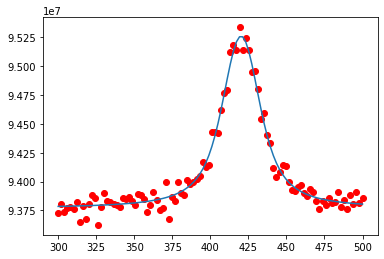

6.31152655176255 11.069738545725693


In [5]:
#let's fit the ideal voigt to the observed noisey data
x=vArr #this is convenient
y=imagesSumArr #this is convenient

v0Guess=vArr[np.argmax(imagesSumArr)] #guess of the value for v0
aGuess=np.max(imagesSumArr)-np.min(imagesSumArr) #guess of the value for a
sigmaGuess=10 #guess for sigma, MHz
gammaGuess=10 #guess for gamma, MHz
bGuess=np.min(imagesSumArr) #guess for b value, or the offset.
guess=[v0Guess,aGuess,sigmaGuess,gammaGuess,bGuess] #list of all the guesses so we can feed it to curve_fit

params,pcov=spo.curve_fit(voigt,x,y,p0=guess) #this functino returns two arrays. The first array contains our
    #optimal parameters. The second array is 2D (numParams x numParams) and represents the "covariance matrix".
    #We can use this matrix to get the random error (standard deviation actually) of our optimal parameters. 
    #This is of course assuming our error is described by a gaussian process. This error will not take systematic 
    #error into account such as having a constant wrong value offset somewhere.

paramError = np.sqrt(np.diag(pcov)) #see the docs of curve_fit to see an explanation of this
billy
plt.scatter(vArr,imagesSumArr,c='red')
plt.plot(vArr,voigt(vArr,*params))
plt.show()
sigma=params[2]
sigmaError=paramError[2]
gamma=params[3]
gammaError=paramError[3]
print(sigma,gamma)

For an explanation of how to relate the width of the gaussian portion of the voigt see this wiki article. This phenomena is called doppler broadening. Remember, our voigt represents a convolution of the lorentzian profile, which is an inherent feature of many atomic transitions, and a gaussian which represents the cloud of atoms having a temperature and bouncing around. The gaussian will tell us how hot the cloud is, specifically the standard deviation of the gaussian.
https://en.wikipedia.org/wiki/Doppler_broadening

Finally, we can also get our error on the temperature with some simple math

$T=\frac{(\gamma/f_0)^2 mc^2}{8 k_b \log(2)}$

where $\gamma$ is the standard deviation of our gaussian. Next

$T+\Delta T=\frac{((\gamma+\Delta \gamma)/f_0)^2 m c^2}{8 k_b \log(2)}$

expanding this gives

$T+\Delta T=(\gamma+\Delta \gamma^2+2 \Delta \gamma \gamma) \alpha$

where

$\alpha=\frac{(1/f_0)^2 mc^2}{8 k_b \log(2)}$

and thus we see

$\Delta T=  \frac{((\Delta \gamma^2+2 \Delta \gamma \gamma)/f_0)^2 mc^2}{8 k_b \log(2)}$

In [17]:
#We can use the value we found for gamma to calculate the temperature.
lam=671E-9 #wavelength of the transition, m
c=3E8 #speed of light, m/s
f0=(c/lam)/1E6 #frequency of the transition, MHz
m=1.16E-26 #mass of lithium atom, kg
kb=1.38E-23 #boltzman constant, SI


T=(gamma/f0)**2 *m*c**2/(8*kb*np.log(2)) 
TError=(gammaError**2+2*gammaError*gamma)*(1/f0)**2*m*c**2/(8*kb*np.log(2))
T=T*1E3 #convert to mk
TError=TError*1E3
TError

2.5611403047478256

Let's make a pretty graph of our fit.

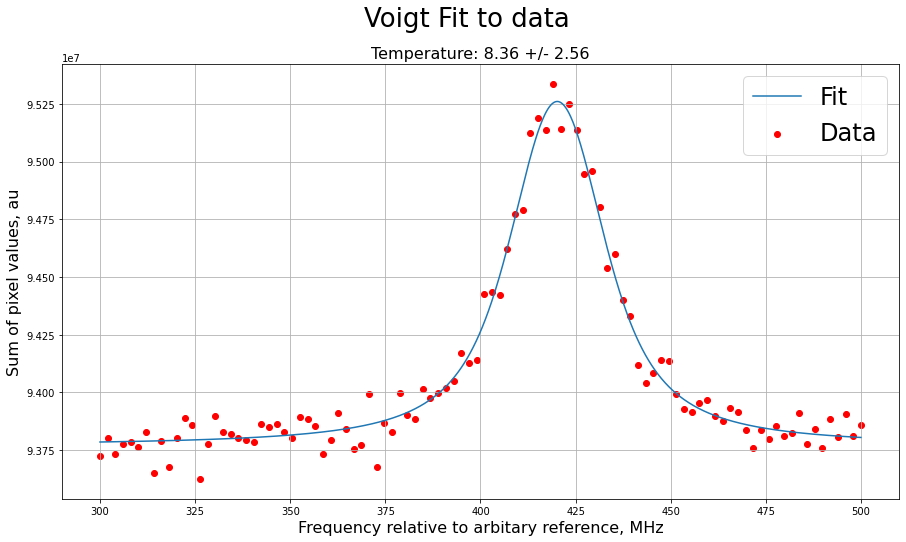

In [31]:
TPlot=np.round(T,2) #we don't need all those digits. something something sig figs
TErrorPlot=np.round(TError,2)

vArrDense=np.linspace(vArr[0],vArr[-1],num=1000) #make a new dense array so the fit plot looks nice
plt.figure(figsize=(15,8))
plt.suptitle("Voigt Fit to data",fontsize=26) #super title
plt.title("Temperature: "+str(TPlot)+' +/- '+str(TErrorPlot),fontsize=16) #normal title, or sub title
plt.scatter(vArr,imagesSumArr,c='red',label='Data')
plt.plot(vArrDense,voigt(vArrDense,*params),label='Fit')
plt.xlabel("Frequency relative to arbitary reference, MHz",fontsize=16)
plt.ylabel("Sum of pixel values, au",fontsize=16)
plt.legend(prop={'size':24})
plt.grid()
plt.show()